<a href="https://www.kaggle.com/code/klyushnik/stacking-classifier-and-synthetic-df?scriptVersionId=168458119" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
! pip install sdv
! pip install iterative-stratification

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faulty-steel-plates/faults.csv
/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv
INFO: pip is looking at multiple versions of sdmetrics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.34
    Uninstalling boto

#                        Loading CSV

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
df_org = pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')

train = pd.concat([train, df_org], ignore_index=True)
print('Shape train is', train.shape, 'shape test is', test.shape)

y_list = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
print('Our proba_columns:', y_list)

Shape train is (21160, 35) shape test is (12814, 28)
Our proba_columns: ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']


In [3]:
train = train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
print('Shape train is', train.shape, 'shape test is', test.shape)

train = train.drop(columns = ['id'])
test = test.drop(columns = ['id'])

print('Shape train is', train.shape, 'shape test is', test.shape)

Shape train is (21160, 35) shape test is (12814, 28)
Shape train is (21160, 34) shape test is (12814, 27)


# Profiling Report

In [4]:
# from ydata_profiling import ProfileReport

# ProfileReport(train, title="Profiling Report")

# Synthetic Data Vault

In [5]:
from sdv.single_table import CTGANSynthesizer
import sdv
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train)

metadata.validate_data(data=train)

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(train)

synthetic_data = synthesizer.sample(num_rows=500) #Shape train is (21160, 34)
print(f'Synthetic Data{synthetic_data.shape}')

from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=train,
    synthetic_data=synthetic_data,
    metadata=metadata
)

train = pd.concat([train, synthetic_data], ignore_index=True)
print('Shape train is', train.shape, 'shape test is', test.shape)

Synthetic Data(500, 34)
Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 346.89it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Shape train is (21660, 34) shape test is (12814, 27)


In [6]:
train['X_range'] = (train['X_Maximum'] - train['X_Minimum'])
train['Y_range'] = (train['Y_Maximum'] - train['Y_Minimum'])

train['Luminosity_range'] = (train['Maximum_of_Luminosity'] - train['Minimum_of_Luminosity'])

train['Areas'] = np.exp(train['LogOfAreas'])
train['X_Index'] = np.exp(train['Log_X_Index'])
train['Y_Index'] = np.exp(train['Log_Y_Index'])

test['X_range'] = (test['X_Maximum'] - test['X_Minimum'])
test['Y_range'] = (test['Y_Maximum'] - test['Y_Minimum']) 

test['Luminosity_range'] = (test['Maximum_of_Luminosity'] - test['Minimum_of_Luminosity']) 

test['Areas'] = np.exp(test['LogOfAreas'])
test['X_Index'] = np.exp(test['Log_X_Index'])
test['Y_Index'] = np.exp(test['Log_Y_Index'])

print('Shape train is', train.shape, 'shape test is', test.shape)

Shape train is (21660, 40) shape test is (12814, 33)


#  Define X,y


In [7]:
X = train.drop(columns= y_list)
y = train[y_list]
X_total = test

work_list = X.columns
print(f'Shape X = {X.shape},shape y = {y.shape},shape X_total = {X_total.shape} and our columns,{work_list}')

X_df = X.copy(deep = True)
X_df_test = X_total.copy(deep = True)
print(f'Shape X = {X_df.shape},shape y = {y.shape},shape X_total =, {X_df_test.shape}')

Shape X = (21660, 33),shape y = (21660, 7),shape X_total = (12814, 33) and our columns,Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'X_range', 'Y_range', 'Luminosity_range', 'Areas',
       'X_Index', 'Y_Index'],
      dtype='object')
Shape X = (21660, 33),shape y = (21660, 7),shape X_total =, (12814, 33)


# LabelEncoder 

In [8]:
y['target'] = np.where(y['Pastry']==1, 'Pastry',
                           np.where(y['Z_Scratch']==1, 'Z_Scratch',
                                    np.where(y['K_Scatch']==1, 'K_Scatch',
                                             np.where(y['Stains']==1, 'Stains',
                                                      np.where(y['Dirtiness']==1, 'Dirtiness',
                                                               np.where(y['Bumps']==1, 'Bumps', 'Other_Faults'))))))

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y['target'])
print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 33) , y shape :(21660,), X_test shape :(12814, 33)


#  Сonvert and add data

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing

In [11]:
class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

class Preprocessor:
    def __init__(self, agg_col, agg_func, group_cols):
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.group_cols = group_cols
        
    def preprocess(self, X, X_total):    
        agg_train, agg_test = [], []
        for group_col in self.group_cols:
            agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=self.agg_col, agg_func=self.agg_func)
            agg_extractor.fit(pd.concat([X, X_total], axis=0))
            agg_train.append(agg_extractor.transform(X))
            agg_test.append(agg_extractor.transform(X_total))
        X = pd.concat([X] + agg_train, axis=1)
        X_total = pd.concat([X_total] + agg_test, axis=1)
        
        X = X.fillna(0)
        X_total = X_total.fillna(0)
        return X, X_total

In [12]:
agg_col = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']

agg_func = ['mean', 'std']

group_cols = [['X_Minimum'], ['X_Maximum'], ['Y_Minimum'], ['Y_Maximum'], ['Pixels_Areas'],
              ['Minimum_of_Luminosity'], ['Maximum_of_Luminosity'], ['Length_of_Conveyer'],
              ['TypeOfSteel_A300'], ['TypeOfSteel_A400'], ['Steel_Plate_Thickness'],
              ['Minimum_of_Luminosity', 'Maximum_of_Luminosity'], ['Length_of_Conveyer','TypeOfSteel_A300'],
              [ 'TypeOfSteel_A400', 'Steel_Plate_Thickness'],      
              ['Edges_Index', 'Empty_Index'],['Edges_X_Index', 'Edges_Y_Index'], 
              ['Outside_Global_Index', 'LogOfAreas'],[ 'Log_X_Index', 'Log_Y_Index'], 
              ['Orientation_Index', 'Luminosity_Index'],             
              ['Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer'],
               ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness'],
               ['Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index'],
               ['Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas'],
               ['Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index']]

pp = Preprocessor(agg_col, agg_func, group_cols)
X, X_total = pp.preprocess(X, X_total)
print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 1329) , y shape :(21660,), X_test shape :(12814, 1329)


In [13]:
transform = PowerTransformer(method='yeo-johnson')
transform2 = QuantileTransformer(n_quantiles=10, random_state=0)

for i in work_list[1:]:
    X[i+'+log'] = (X[i]+1).transform(np.log)
    X_total[i+'+log'] =(X_total[i]+1).transform(np.log)
    
    X[i+'+log1'] = (X[i]+1).transform(np.log1p)
    X_total[i+'+log1'] =(X_total[i]+1).transform(np.log1p)
    
    X[i+'+y_j'] = transform.fit_transform(X[[i]])
    X_total[i+'+y_j'] = transform.fit_transform(X_total[[i]])
    
    X[i+'+q_t'] = transform2.fit_transform(X[[i]])
    X_total[i+'+q_t'] = transform2.fit_transform(X_total[[i]])
       
    X[i+'+sqrt'] = (X[i]+1).transform(np.sqrt)
    X_total[i+'+sqrt'] =(X_total[i]+1).transform(np.sqrt)
    
print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 1489) , y shape :(21660,), X_test shape :(12814, 1489)


# Polynomial Features

In [14]:
def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

output_df = PolynomialFeatures_labeled(X[work_list[1:]],2)
output_df_t = PolynomialFeatures_labeled(X_total[work_list[1:]],2)

X =  pd.concat([X.reset_index(drop=True), output_df], axis = 1)
X_total = pd.concat([X_total.reset_index(drop=True), output_df_t], axis = 1)

print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 2050) , y shape :(21660,), X_test shape :(12814, 2050)


In [15]:
X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_total = X_total.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 2050) , y shape :(21660,), X_test shape :(12814, 2050)


# Threshold

In [16]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

In [17]:
X = variance_threshold(X,0.4)
list_name = (X.columns)
X_total = X_total[list_name]

print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 1099) , y shape :(21660,), X_test shape :(12814, 1099)


# PCA

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalComponents_test = pca.fit_transform(X_total)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDftest = pd.DataFrame(data = principalComponents_test
             , columns = ['principal component 1', 'principal component 2'])

X = pd.concat([X_df, principalDf], axis = 1)
X_total = pd.concat([X_df_test, principalDftest], axis = 1)

print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(21660, 35) , y shape :(21660,), X_test shape :(12814, 35)


# Model 

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_total = scaler.transform(X_total)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from mlxtend.classifier import StackingCVClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report
import optuna
from sklearn.metrics import accuracy_score
import itertools
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [22]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()

In [23]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1500),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize",pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=200, reduction_factor=2
    ))
study.optimize(objective, n_trials=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-23 17:43:54,133] A new study created in memory with name: no-name-bdb62ef7-4966-4db5-bbf7-46676ce5cc2b
[I 2024-03-23 17:44:56,717] Trial 0 finished with value: 0.5977223761157279 and parameters: {'iterations': 308, 'learning_rate': 0.003543827605312527, 'depth': 9, 'l2_leaf_reg': 1.58610639875162e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 1.5501743305584854e-05, 'bagging_temperature': 4.25113791381767, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 0 with value: 0.5977223761157279.
[I 2024-03-23 17:45:06,875] Trial 1 finished with value: 0.5831024930747922 and parameters: {'iterations': 385, 'learning_rate': 0.0012970749488031249, 'depth': 5, 'l2_leaf_reg': 1.054352927137935e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 1.4480340273387804, 'bagging_temperature': 3.612535878483354, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 0 with value: 0.5977223761157279.
[I 2024-03-23 17:50:04,173] Trial 2 finished with value: 0.6024930747922438 and param

Number of finished trials: 150
Best trial:
  Value: 0.626346568174823
  Params: 
    iterations: 1152
    learning_rate: 0.03997219728379023
    depth: 5
    l2_leaf_reg: 0.003401546794327971
    bootstrap_type: Bayesian
    random_strength: 0.9476593800528091
    bagging_temperature: 0.4641689180401458
    od_type: IncToDec
    od_wait: 34


              precision    recall  f1-score   support

           0       0.55      0.49      0.52      1554
           1       0.67      0.25      0.37       181
           2       0.89      0.90      0.90      1163
           3       0.56      0.66      0.61      2518
           4       0.48      0.23      0.31       498
           5       0.76      0.81      0.79       209
           6       0.61      0.67      0.64       375

    accuracy                           0.63      6498
   macro avg       0.65      0.58      0.59      6498
weighted avg       0.62      0.63      0.62      6498



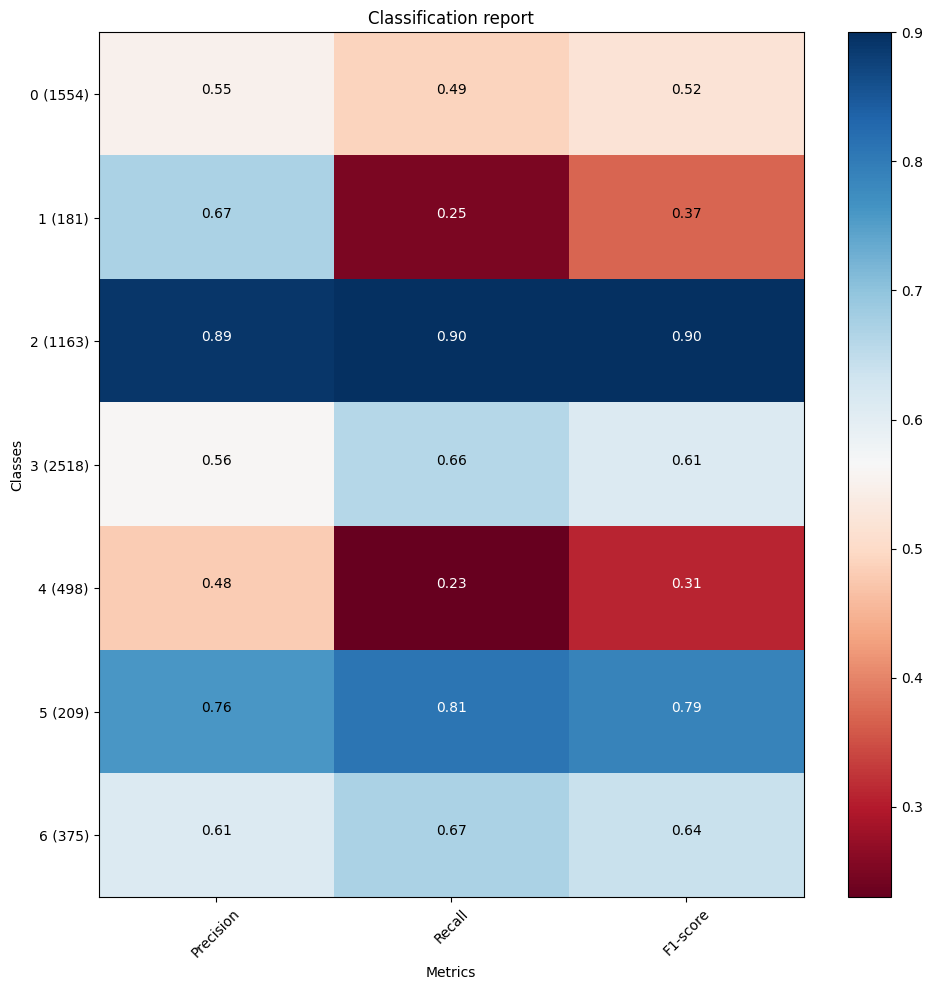

In [24]:
ct_best = study.best_params
model = CatBoostClassifier(**ct_best, verbose = 0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
clf =classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

In [25]:
train_y_label = y_train
valid_y_label = y_test
dtrain = lgb.Dataset(X_train, label=train_y_label)

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    param = {
       'metric': 'multi_logloss',
        'objective': 'multiclass',
        'num_class': 16,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter' : False,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1300),
        'verbose': -1
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = []
    for i in range(0,len(preds)):
        pred_labels.append(np.argmax(preds[i]))
    accuracy = cal_acc(valid_y_label, pred_labels)
    return accuracy

def cal_acc(true, pred):
    return np.mean(true==pred)

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=200, reduction_factor=2    ))
study.optimize(objective, n_trials=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-23 20:46:53,868] A new study created in memory with name: no-name-788a3781-8e21-4dd2-9b1e-e3c2b1825fbe
[I 2024-03-23 20:47:34,647] Trial 0 finished with value: 0.5958756540473992 and parameters: {'lambda_l1': 0.46032457854921055, 'lambda_l2': 2.314374103183484e-07, 'num_leaves': 146, 'feature_fraction': 0.9646294913032832, 'bagging_fraction': 0.8147313573557602, 'bagging_freq': 1, 'min_child_samples': 91, 'n_estimators': 1010}. Best is trial 0 with value: 0.5958756540473992.
[I 2024-03-23 20:47:46,481] Trial 1 finished with value: 0.6166512773160973 and parameters: {'lambda_l1': 5.8120184393624275, 'lambda_l2': 6.878640619094084, 'num_leaves': 2, 'feature_fraction': 0.6520960995168976, 'bagging_fraction': 0.8500630725320212, 'bagging_freq': 5, 'min_child_samples': 77, 'n_estimators': 1086}. Best is trial 1 with value: 0.6166512773160973.
[I 2024-03-23 20:48:33,044] Trial 2 finished with value: 0.6069559864573715 and parameters: {'lambda_l1': 0.000838416983146898, 'lambda_l2'

Number of finished trials: 150
Best trial:
  Value: 0.6209602954755309
  Params: 
    lambda_l1: 9.799187360999219e-06
    lambda_l2: 6.39504880807409
    num_leaves: 13
    feature_fraction: 0.8296702032955496
    bagging_fraction: 0.9961851611701286
    bagging_freq: 5
    min_child_samples: 32
    n_estimators: 177


              precision    recall  f1-score   support

           0       0.54      0.50      0.52      1554
           1       0.64      0.27      0.38       181
           2       0.89      0.91      0.90      1163
           3       0.56      0.65      0.60      2518
           4       0.45      0.23      0.30       498
           5       0.72      0.85      0.78       209
           6       0.62      0.69      0.65       375

    accuracy                           0.62      6498
   macro avg       0.63      0.58      0.59      6498
weighted avg       0.62      0.62      0.61      6498



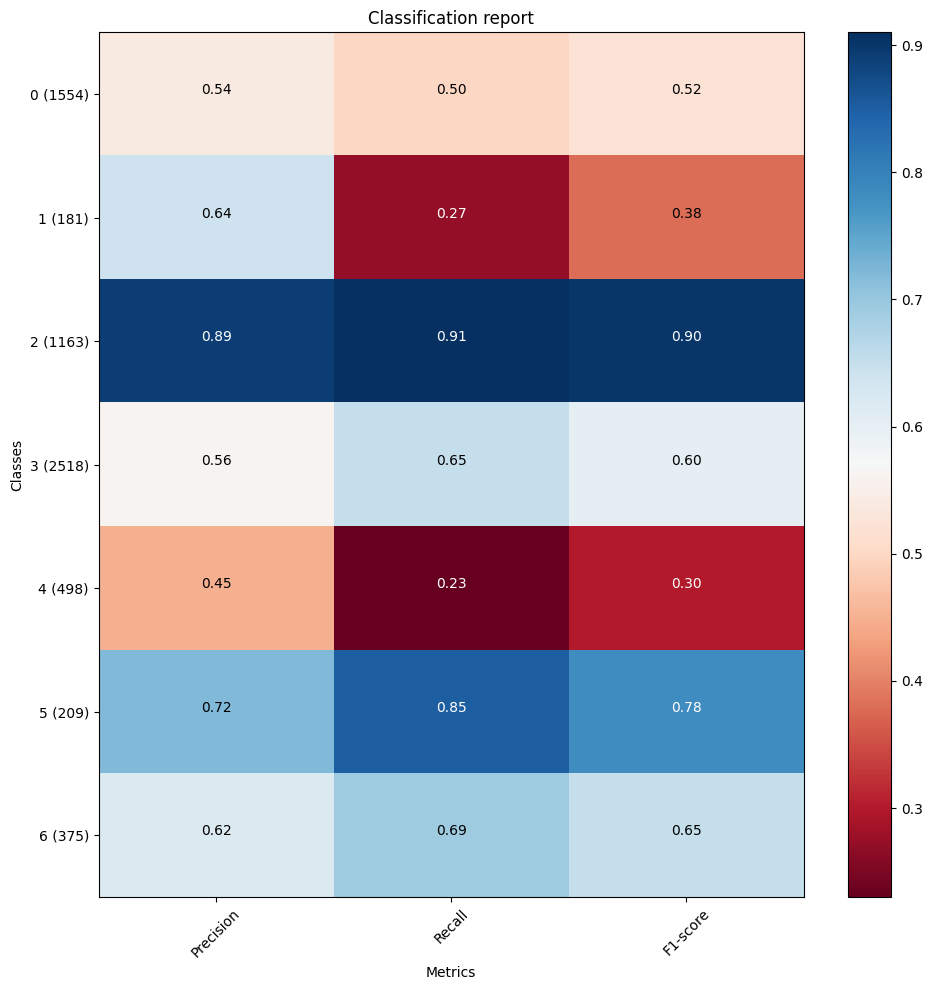

In [26]:
lgb_best = study.best_params
model = lgb.LGBMClassifier(**lgb_best,verbose=-1)
model.fit(X_train, train_y_label)
y_pred = model.predict(X_test)
clf =classification_report(valid_y_label, y_pred)
plot_classification_report(clf)
print(clf)

In [27]:
train_y_label = y_train
valid_y_label = y_test
train_x_tr, valid_x_es, train_y_tr, valid_y_es = train_test_split(X_train, train_y_label, test_size=0.2)

dtrain = xgb.DMatrix(train_x_tr, label=train_y_tr)
dtest = xgb.DMatrix(X_test, label=valid_y_label)

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 7,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "early_stopping_rounds":200,
        "evals":([valid_x_es,valid_y_es]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1300)
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y_label, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=200, reduction_factor=2
    ))
study.optimize(objective, n_trials=150, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-23 21:45:55,911] A new study created in memory with name: no-name-af4450d8-5703-4ad6-a622-282978a952ce
[I 2024-03-23 21:45:56,955] Trial 0 finished with value: 0.6009541397353032 and parameters: {'booster': 'gbtree', 'lambda': 0.41264382462951676, 'alpha': 0.05188899482380204, 'subsample': 0.8543682874060192, 'colsample_bytree': 0.4461907729980545, 'n_estimators': 1136, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.7760643966300774, 'gamma': 0.4462780954793742, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6009541397353032.
[I 2024-03-23 21:45:57,965] Trial 1 finished with value: 0.5944906124961526 and parameters: {'booster': 'dart', 'lambda': 0.0009314822755228997, 'alpha': 0.7517747159257353, 'subsample': 0.2135045956447062, 'colsample_bytree': 0.7901113829696489, 'n_estimators': 260, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.0029145581282218175, 'gamma': 9.687632453276386e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 't

Number of finished trials: 150
Best trial:
  Value: 0.6204986149584487
  Params: 
    booster: gbtree
    lambda: 3.012438297072006e-05
    alpha: 0.025080662243378113
    subsample: 0.6038599672758886
    colsample_bytree: 0.9041205354138775
    n_estimators: 442
    max_depth: 9
    min_child_weight: 4
    eta: 0.0971309070980804
    gamma: 0.006557345001712132
    grow_policy: depthwise


              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1554
           1       0.67      0.21      0.32       181
           2       0.89      0.89      0.89      1163
           3       0.55      0.65      0.60      2518
           4       0.48      0.24      0.32       498
           5       0.72      0.81      0.76       209
           6       0.62      0.69      0.65       375

    accuracy                           0.62      6498
   macro avg       0.64      0.57      0.58      6498
weighted avg       0.62      0.62      0.61      6498



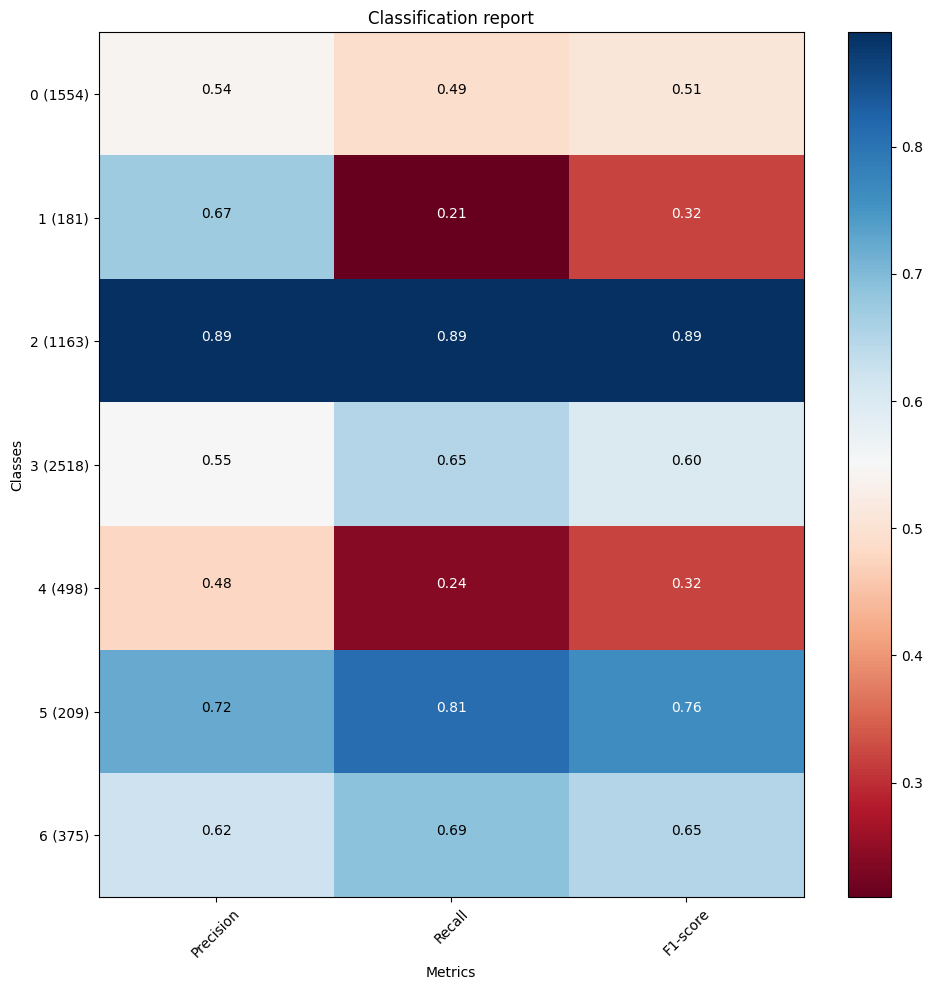

In [28]:
xgb_best = study.best_params
model = xgb.XGBClassifier(**xgb_best)
model.fit(train_x_tr,train_y_tr,eval_set=[(valid_x_es,valid_y_es)],early_stopping_rounds=200,verbose=False)
y_pred = model.predict(X_test)
clf =classification_report(valid_y_label, y_pred)
plot_classification_report(clf)
print(clf)

In [29]:
print(f'CatBoostClassifier:{ct_best}')

print(f'LGBMClassifier: {lgb_best}')

print(f'XGBClassifier:{xgb_best}')

xgb_pr = {'objective': 'multi:softmax','num_class': 7,'tree_method': 'hist','max_depth': 10,'learning_rate': 0.03513993699286939,
          'n_estimators': 858,'gamma': 2.518374355263247,'min_child_weight': 3,'colsample_bytree': 0.3354444954368183,
          'subsample': 0.7926423415125474}

lgb_pr = {'objective': 'multiclass','num_class': 7,'n_estimators': 487,'learning_rate': 0.01769733167760597,'max_depth': 8,
          'reg_alpha': 1.3066859935623705,'reg_lambda': 5.254896833391085,'num_leaves': 19,'subsample': 0.31249582747908944,
          'colsample_bytree': 0.1941606712019325}

CatBoostClassifier:{'iterations': 1152, 'learning_rate': 0.03997219728379023, 'depth': 5, 'l2_leaf_reg': 0.003401546794327971, 'bootstrap_type': 'Bayesian', 'random_strength': 0.9476593800528091, 'bagging_temperature': 0.4641689180401458, 'od_type': 'IncToDec', 'od_wait': 34}
LGBMClassifier: {'lambda_l1': 9.799187360999219e-06, 'lambda_l2': 6.39504880807409, 'num_leaves': 13, 'feature_fraction': 0.8296702032955496, 'bagging_fraction': 0.9961851611701286, 'bagging_freq': 5, 'min_child_samples': 32, 'n_estimators': 177}
XGBClassifier:{'booster': 'gbtree', 'lambda': 3.012438297072006e-05, 'alpha': 0.025080662243378113, 'subsample': 0.6038599672758886, 'colsample_bytree': 0.9041205354138775, 'n_estimators': 442, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0971309070980804, 'gamma': 0.006557345001712132, 'grow_policy': 'depthwise'}


In [30]:
clf = CatBoostClassifier(**ct_best, grow_policy ='Depthwise',leaf_estimation_method = 'Newton', 
                         loss_function = 'MultiClass',verbose = 0)
clf1 = lgb.LGBMClassifier(**lgb_best,verbose=-1)
clf2 = xgb.XGBClassifier(**xgb_best)
clf3 = CalibratedClassifierCV(clf, cv=KFold(n_splits=5))
# clf4 = xgb.XGBClassifier(**xgb_pr)
# clf5 = lgb.LGBMClassifier(**lgb_pr,verbose=-1)

sclf = StackingCVClassifier(classifiers = [clf,clf1,clf2,clf3,
                                          ],#clf4, clf5
                            shuffle = False,
                            use_probas = True,
                            cv = StratifiedKFold(n_splits=5),
                            meta_classifier = xgb.XGBClassifier(**xgb_best))

classifiers = {"cat" : clf,"lgb": clf1,"xgb": clf2, 'calib':clf3, "Stack": sclf}#'xgb2':clf4,'lgb2': clf5,

In [31]:
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    # Fit classifier
    classifier.fit(X_train, y_train)
    # Save fitted classifier
    classifiers[key] = classifier

In [32]:
for key in classifiers:
# Make prediction on test set
    y_pred_0 = classifiers[key].predict_proba(X_total)

In [33]:
le.classes_

array(['Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry',
       'Stains', 'Z_Scratch'], dtype=object)

# Submit 

In [34]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
sub['Pastry'] = y_pred_0[:, 4]
sub['Z_Scratch'] = y_pred_0[:, 6]
sub['K_Scatch'] = y_pred_0[:, 2]
sub['Stains'] = y_pred_0[:, 5]
sub['Dirtiness'] = y_pred_0[:, 1]
sub['Bumps'] = y_pred_0[:, 0]
sub['Other_Faults'] = y_pred_0[:, 3]
sub.to_csv('submission.csv', index=False)
sub.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.370562,0.000166,0.000052,0.000093,0.004293,0.082621,0.542213
1,19220,0.305144,0.001316,0.001321,0.000041,0.041860,0.030884,0.619433
2,19221,0.000721,0.000790,0.015197,0.000024,0.000535,0.770242,0.212490
3,19222,0.083274,0.000033,0.000068,0.000044,0.000141,0.576822,0.339619
4,19223,0.003511,0.000817,0.000076,0.000366,0.002205,0.741070,0.251955
